# Introduction

## Resources

- https://opensource.com/article/19/3/natural-language-processing-tools



## NLP pipeline diagram

Practical Natural Language Processing: A Comprehensive Guide to Building Real-World NLP Systems, Page 38

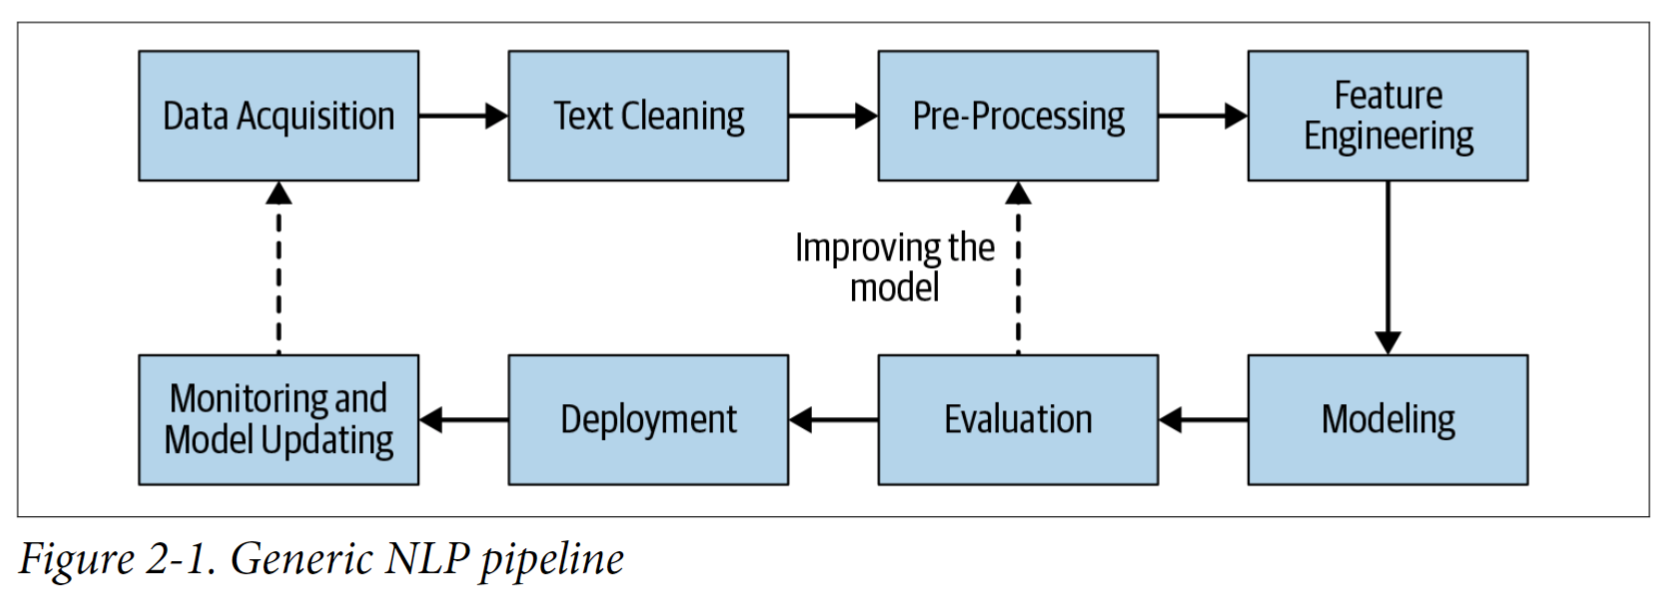

In [851]:
from IPython.display import Image
Image(filename="img/NLP pipeline.png") 

# NLP pipeline

## Package imports

In [870]:
from enum import Enum
import numpy as np
import pandas as pd

## Data acquisition

### Sources

1. ISIC Revision 4 - https://unstats.un.org/unsd/classifications/Econ/isic
2. NACE Revision 2 - 
3. SSIC 2020 - https://www.singstat.gov.sg/standards/standards-and-classifications/ssic
4. WZ Issue 2008 - https://www.klassifikationsserver.de/klassService/jsp/common/url.jsf?variant=wz2008&lang=EN

## Text cleaning

- Cleared the print area to remove warnings produced after reading from spreadsheets

### Helper functions

In [853]:
# Insert the list of levels
def insert_levels(df):
    levels = df.index.str.len()
    df.insert(0, "Level", levels)

# Insert the list of parents given an industry classification
def insert_parents(df):
    parents = []
    history = []
    prev = {"Level": 0, "Code": ""}

    # Iterate through the dataframe to deduce the parent
    for row in df.itertuples():
        prev_level = len(history)
        current_level = row.Level
        current_code = row.Index
        
        ## If the current level is '1'
        if current_level == 1:
            current_parent = ""
            history = [current_code]
            
        ## If the current level is lower than the previous level
        elif current_level > prev_level:
            current_parent = history[prev_level - 1]
            history.append(current_code)
            
        ## If the current level is higher than the previous level
        elif current_level < prev_level:
            current_parent = history[(current_level - 1) - 1]
            del history[current_level - 1:]
            history.append(current_code)
        
        else:
            current_parent = history[(current_level - 1) - 1]
        
        parents.append(current_parent)
        prev.update({"Level": current_level, "Code": current_code})
        
    # Insert the list as a column
    df.insert(1, "Parent", parents)

# Usual string cleaning techniques
def default_clean(df):
    # Normalisation (lowercase strings)
    
    ## If the dataframe doesn't ISIC code data
    if "ISIC code" in df:
        df.iloc[:, 2:-1] = df.loc[:].iloc[:-1].map(
            lambda x: x.lower() if isinstance(x, str) else x
        )
        
    ## If the dataframe has ISIC code data
    else:
        df.loc[:, "Description":] = df.loc[:, "Description":].map(
            lambda x: x.lower() if isinstance(x, str) else x
        )
    
    # Replace punctuation with empty strings
    df.loc[:, "Description":] = df.loc[:, "Description":].replace(r"[^\w\s]+", " ", regex=True)
    
    # Replace newlines and multiple spaces with whitespaces
    df.replace([r"\n", r" +"], " ", regex=True, inplace=True)
    
    # Strip leading and trailing whitespaces
    df.loc[:, "Description":] = df.loc[:, "Description":].map(lambda x: x.strip() if isinstance(x, str) else x)

### Cleaning ISIC data

In [854]:
# Read the CSV file
ISIC_df = pd.read_csv("data/ISIC Rev. 4.csv")

# Set the 'Code' column as the index
ISIC_df = ISIC_df.set_index("Code")

# Add a 'Level' column
insert_levels(ISIC_df)

# Add a 'Parent' column
insert_parents(ISIC_df)

# Extra cleaning techniques
default_clean(ISIC_df)

ISIC_df.head()

,Level,Parent,Description
Code,,,
A,1,,agriculture forestry and fishing
01,2,A,crop and animal production hunting and related...
011,3,01,growing of non perennial crops
0111,4,011,growing of cereals except rice leguminous crop...
0112,4,011,growing of rice


### Cleaning NACE data

In [868]:
# Read the Excel file
NACE_df = pd.read_excel("data/NACE Rev. 2.xlsx")

# Replace NaN values with empty strings
NACE_df = NACE_df.fillna("")

# Set the 'Code' column as the index
NACE_df = NACE_df.set_index("Code")

# Rename columns
NACE_df = NACE_df.rename(columns={
    "This item includes": "Examples",
    "This item excludes": "Exclusions",
    "Reference to ISIC Rev. 4": "ISIC code"
})

# Concatenate the columns "This item also includes" and "Definition"
NACE_df["Examples"] += " " + NACE_df["This item also includes"]

# Drop columns
NACE_df = NACE_df.drop(columns=["Order", "This item also includes"])

# Extra cleaning techniques
# default_clean(NACE_df)

NACE_df.head()

,Level,Parent,Description,Definition,Examples,Exclusions,ISIC code
Code,,,,,,,
A,1,,"AGRICULTURE, FORESTRY AND FISHING",This section includes the exploitation of vege...,,,A
01,2,A,"Crop and animal production, hunting and relate...","This division includes two basic activities, n...",,Agricultural activities exclude any subsequent...,01
01.1,3,01,Growing of non-perennial crops,This group includes the growing of non-perenni...,,,011
01.11,4,01.1,"Growing of cereals (except rice), leguminous c...",This class includes all forms of growing of ce...,,"This class excludes:\n- growing of rice, see 0...",0111
01.12,4,01.1,Growing of rice,This class includes:\n- growing of rice (inclu...,,,0112


### Cleaning SSIC v1 data

In [856]:
# Read the Excel file
SSIC_v1_df = pd.read_excel("data/SSIC 2020 v1.xlsx")

# Drop columns
SSIC_v1_df = SSIC_v1_df.drop(columns=["ISIC Rev. 4 Part", "ISIC Rev. 4 Title"])

# Rename columns
SSIC_v1_df = SSIC_v1_df.rename(columns={
    "SSIC 2020 Title": "Description",
    "SSIC 2020": "Code",
    "ISIC Rev. 4": "ISIC code"
})

# Set the 'Code' column as the index
SSIC_v1_df = SSIC_v1_df.set_index("Code")

# Add a 'Level' column
insert_levels(SSIC_v1_df)

# Extra cleaning techniques
default_clean(SSIC_v1_df)

SSIC_v1_df.head()

,Level,Description,ISIC code
Code,,,
01111,5,Growing of leafy and fruit vegetables,113
01112,5,Growing of mushrooms,113
01113,5,Growing of root crops,113
01119,5,Growing of food crops non hydroponics n e c,111
01119,5,Growing of food crops non hydroponics n e c,112


### Cleaning SSIC v2 data

In [857]:
# Read the Excel file
SSIC_v2_df = pd.read_excel("data/SSIC 2020 v2.xlsx")

# Drop columns
SSIC_v2_df = SSIC_v2_df.drop(columns=["Cross References", "Groups Classified Under this Code"])

# Replace '<Blank>' with empty strings
SSIC_v2_df = SSIC_v2_df.replace(to_replace="<Blank>", value="")

# Rename columns
SSIC_v2_df = SSIC_v2_df.rename(columns={
    "SSIC 2020 Title": "Description",
    "SSIC 2020": "Code",
    "Detailed Definitions": "Definition",
    "Examples of Activities Classified Under this Code": "Examples"
})

# Set the 'Code' column as the index
SSIC_v2_df = SSIC_v2_df.set_index("Code")

# Add a 'Level' column
insert_levels(SSIC_v2_df)

# Add a 'Parent' column
insert_parents(SSIC_v2_df)

# Extra cleaning techniques
default_clean(SSIC_v2_df)

SSIC_v2_df.head()

,Level,Parent,Description,Definition,Examples
Code,,,,,
A,1,,agriculture and fishing,,
01,2,A,agriculture and related service activities,,
011,3,01,growing of crops market gardening and horticul...,,
0111,4,011,growing of food crops non hydroponics,,
01111,5,0111,growing of leafy and fruit vegetables,this sub class includes the cultivation of lea...,


### Cleaning WZ data

In [858]:
# Read the Excel file
WZ_df = pd.read_excel("data/WZ Issue 2008.xls", sheet_name="Content")

# Rename columns
WZ_df = WZ_df.rename(columns={"Code WZ 2008": "Code", "Title": "Description"})

# Set the 'Code' column as the index
WZ_df = WZ_df.set_index("Code")

# Add a 'Parent' column
insert_parents(WZ_df)

# Remove columns
WZ_df = WZ_df.drop(columns="Unit(s) of measure")

# Extra cleaning techniques
default_clean(WZ_df)

WZ_df.head()

,Level,Parent,Description
Code,,,
A,1,,agriculture forestry and fishing
01,2,A,crop and animal production hunting and related...
01.1,3,01,growing of non perennial crops
01.11,4,01.1,growing of cereals except rice leguminous crop...
01.11.0,5,01.11,growing of cereals except rice leguminous crop...


## Pre-processing

In [869]:
text = SSIC_v2_df.loc["01413", "Definition"]



# SSIC_v2_df.loc["01413", "Description"] = tokens

# IndustryType
# - Standard
# - Code
# - Level
# - Parent

# Look up data from dataframes and pull up Description
# If they exist, look at Definition, Examples, Exclusions too

# Description is the main feature to compare against
# Definition enforces the description
# Examples supplement the description
# Exclusions supplement the description
# 

()


## Feature engineering

## Modelling

## Evaluation

## Deployment

In [861]:
def get_context(df, code):
    # Code Level Parent
    # Description
    # Definition
    # Examples
    # Exclusions
    
    return

In [862]:
class IndustryClassificationType(Enum):
    ISIC, NACE, SSIC, WZ = range(0, 4)    
    
class IndustryClassification:
    def __init__(self, type, info):
        self.type = type
        self.info = info
        
        match type:
            case IndustryClassificationType.ISIC:
                
                return
            case IndustryClassificationType.NACE:
                
                return
            case IndustryClassificationType.SSIC:
                
                return
            case IndustryClassificationType.WZ:
                
                return